In [2]:
import numpy as np
import pickle
import sys
from typing import List
import torch
import os

In [3]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [4]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [5]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [6]:
from utilities.userfold_framework import *
from Models.AR_EEG_models import *
import Models.model_func as Model_Func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torcheeg.models import EEGNet
from torch import nn


DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]

for r in range(5):
    participants_dictionary=[]
    for i in range(len(participants)):

        train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                          raw_user_fold,
                                                                                          participants,
                                                                                          batch_size=batch_size,
                                                                                          transpose_channels=transpose_channels)

        eegnet= EEGNet(
            chunk_size=input_dim[1],
            num_electrodes=input_dim[0],
            num_classes=classes,
            kernel_1= 32,
            kernel_2=32,
            F1=8,
            F2=16,
            dropout=0.5
        ).to(DEVICE)

    #     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)

        criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
    #     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))

        saved_dir= f"./EEG/saved_models/Userfold/run{r}"
        classifier = LSTM_EEGNet_Wrapper(DEVICE, eegnet, input_dim).to(DEVICE)
        model = EEGNet_IE_HP_Wrapper(DEVICE, classifier, input_dim).to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)


#         train_func= eeg_train
#         model.training_procedure(iteration=n_epochs,
#                                         train_dataloader=train_dataloader,
#                                          val_dataloader=val_dataloader,
#                                          print_cycle=2,
#                                          path=f"./dictionary/intermdiate_dicts",
#                                          loss_func=criterion,
#                                          optimiser=optimizer, #scheduler=scheduler,
#                                          train_func=train_func
#                                         )
#         if model.epoch == n_epochs+1:
#             EPOCH= n_epochs
#         else:
#             EPOCH= model.epoch

#         torch.save(model.state_dict(), 
#                os.path.join(
#                    saved_dir, f"Userfold-{participants[i]}-LSTM_EEGNet-Weight_Multivariate-e{EPOCH}.pt"
#                )
#         )

#         pickle.dump( model.return_IE_weights(), 
#                     open(f"{saved_dir}/Userfold-{participants[i]}-LSTM_EEGNet-Weight_Multivariate-w-e{EPOCH}.pkl", "wb") 
#                    )    

    # OR
        model.load_state_dict(
        torch.load(
            open(
                os.path.join(
                    saved_dir, f"Userfold-{participants[i]}-LSTM_EEGNet-Weight_Multivariate-e{n_epochs}.pt"
                ), "rb"
            )
                  )
        )

        prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)

        ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])

        c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
        print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
        b_acc_list.append(b_acc)
        c0_acc_list.append(c0_acc)
        c1_acc_list.append(c1_acc)
        participants_dictionary.append(dictionary)
#     pickle.dump(participants_dictionary, open(f"{saved_dir}/participant_dictionary-LSTM_EEGNet-Weight_Multivariate.pkl","wb"))


tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


106 18

c0_acc 0.954954954954955 , c1_acc 0.36 , b_acc 0.6574774774774774
106 9

c0_acc 0.9217391304347826 , c1_acc 0.16981132075471697 , b_acc 0.5457752255947498
111 11

c0_acc 0.9024390243902439 , c1_acc 0.20754716981132076 , b_acc 0.5549930971007824
120 8

c0_acc 0.916030534351145 , c1_acc 0.14285714285714285 , b_acc 0.5294438386041439
100 14

c0_acc 0.8547008547008547 , c1_acc 0.2857142857142857 , b_acc 0.5702075702075702
114 6

c0_acc 0.912 , c1_acc 0.12 , b_acc 0.516
110 18

c0_acc 0.88 , c1_acc 0.32142857142857145 , b_acc 0.6007142857142858
110 8

c0_acc 0.873015873015873 , c1_acc 0.13559322033898305 , b_acc 0.5043045466774281
124 14

c0_acc 0.9323308270676691 , c1_acc 0.2545454545454545 , b_acc 0.5934381408065619
126 16

c0_acc 0.9767441860465116 , c1_acc 0.2711864406779661 , b_acc 0.6239653133622388
109 11

c0_acc 0.9159663865546218 , c1_acc 0.22916666666666666 , b_acc 0.5725665266106442
118 21

c0_acc 0.9672131147540983 , c1_acc 0.3888888888888889 , b_acc 0.6780510018214936
1

     accuracy  f1-score
S01  0.788820  0.765777
S02  0.732143  0.673602
S03  0.681818  0.631335
S04  0.689840  0.656955
S05  0.716867  0.650328
S06  0.680000  0.628571
S07  0.685083  0.650415
S08  0.664865  0.590139
S09  0.760638  0.722555
S10  0.696809  0.636876
S11  0.682635  0.631186
S12  0.761364  0.731885
S13  0.720670  0.662612
S14  0.723757  0.675717
S15  0.688525  0.626052
S16  0.721311  0.651921
S17  0.753012  0.727263
S19  0.684783  0.617845
S20  0.811111  0.793027


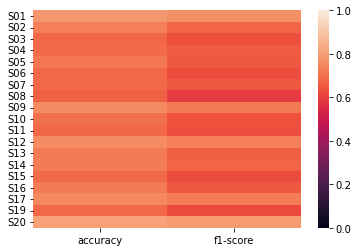

     class0 f1-score  class1 f1-score
S01         0.861789         0.552632
S02         0.832714         0.328358
S03         0.798561         0.243243
S04         0.798611         0.325581
S05         0.826568         0.229508
S06         0.800000         0.200000
S07         0.794224         0.329412
S08         0.790541         0.162162
S09         0.849498         0.415584
S10         0.809365         0.259740
S11         0.801498         0.208955
S12         0.845588         0.475000
S13         0.825175         0.305556
S14         0.825175         0.342105
S15         0.805461         0.219178
S16         0.829431         0.238806
S17         0.839216         0.467532
S19         0.802721         0.216216
S20         0.875912         0.604651


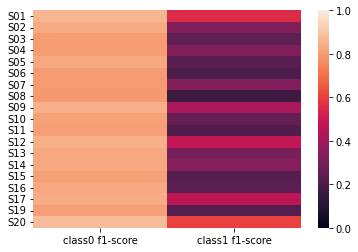

In [6]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)


In [7]:
start=-0.5
step=1.5/(188-1)
timestep_labels=[]
for i in range(input_dim[1]):
    timestep_labels.append(round(start+step*i,3))
    
# timestep_labels

In [8]:
# channel_names=[i for i in range(input_dim[0])]
channel_names=["AFz","F3","F1","Fz","F2","F4","FC5","FC3","FC1","FCz","FC2",
               "FC4","FC6","C5","C3","C1","Cz","C2","C4","C6","CP5","CP3",
               "CP1","CPz","CP2","CP4","CP6","P3","P1","Pz","P2","P4"]

In [9]:
from sklearn.preprocessing import MinMaxScaler

participants_w_list=[]

for i in range(len(participants)):

    w= pickle.load(
        open(f"{saved_dir}/Userfold-{participants[i]}-LSTM_EEGNet-Weight_Multivariate-w-e{EPOCH}.pkl", "rb") 
                    )  
    participants_w_list.append(w)
    
avg_w= np.array(participants_w_list).mean(axis=0)
# scaler= MinMaxScaler()
# scaled_avg_w= scaler.fit_transform(avg_w)

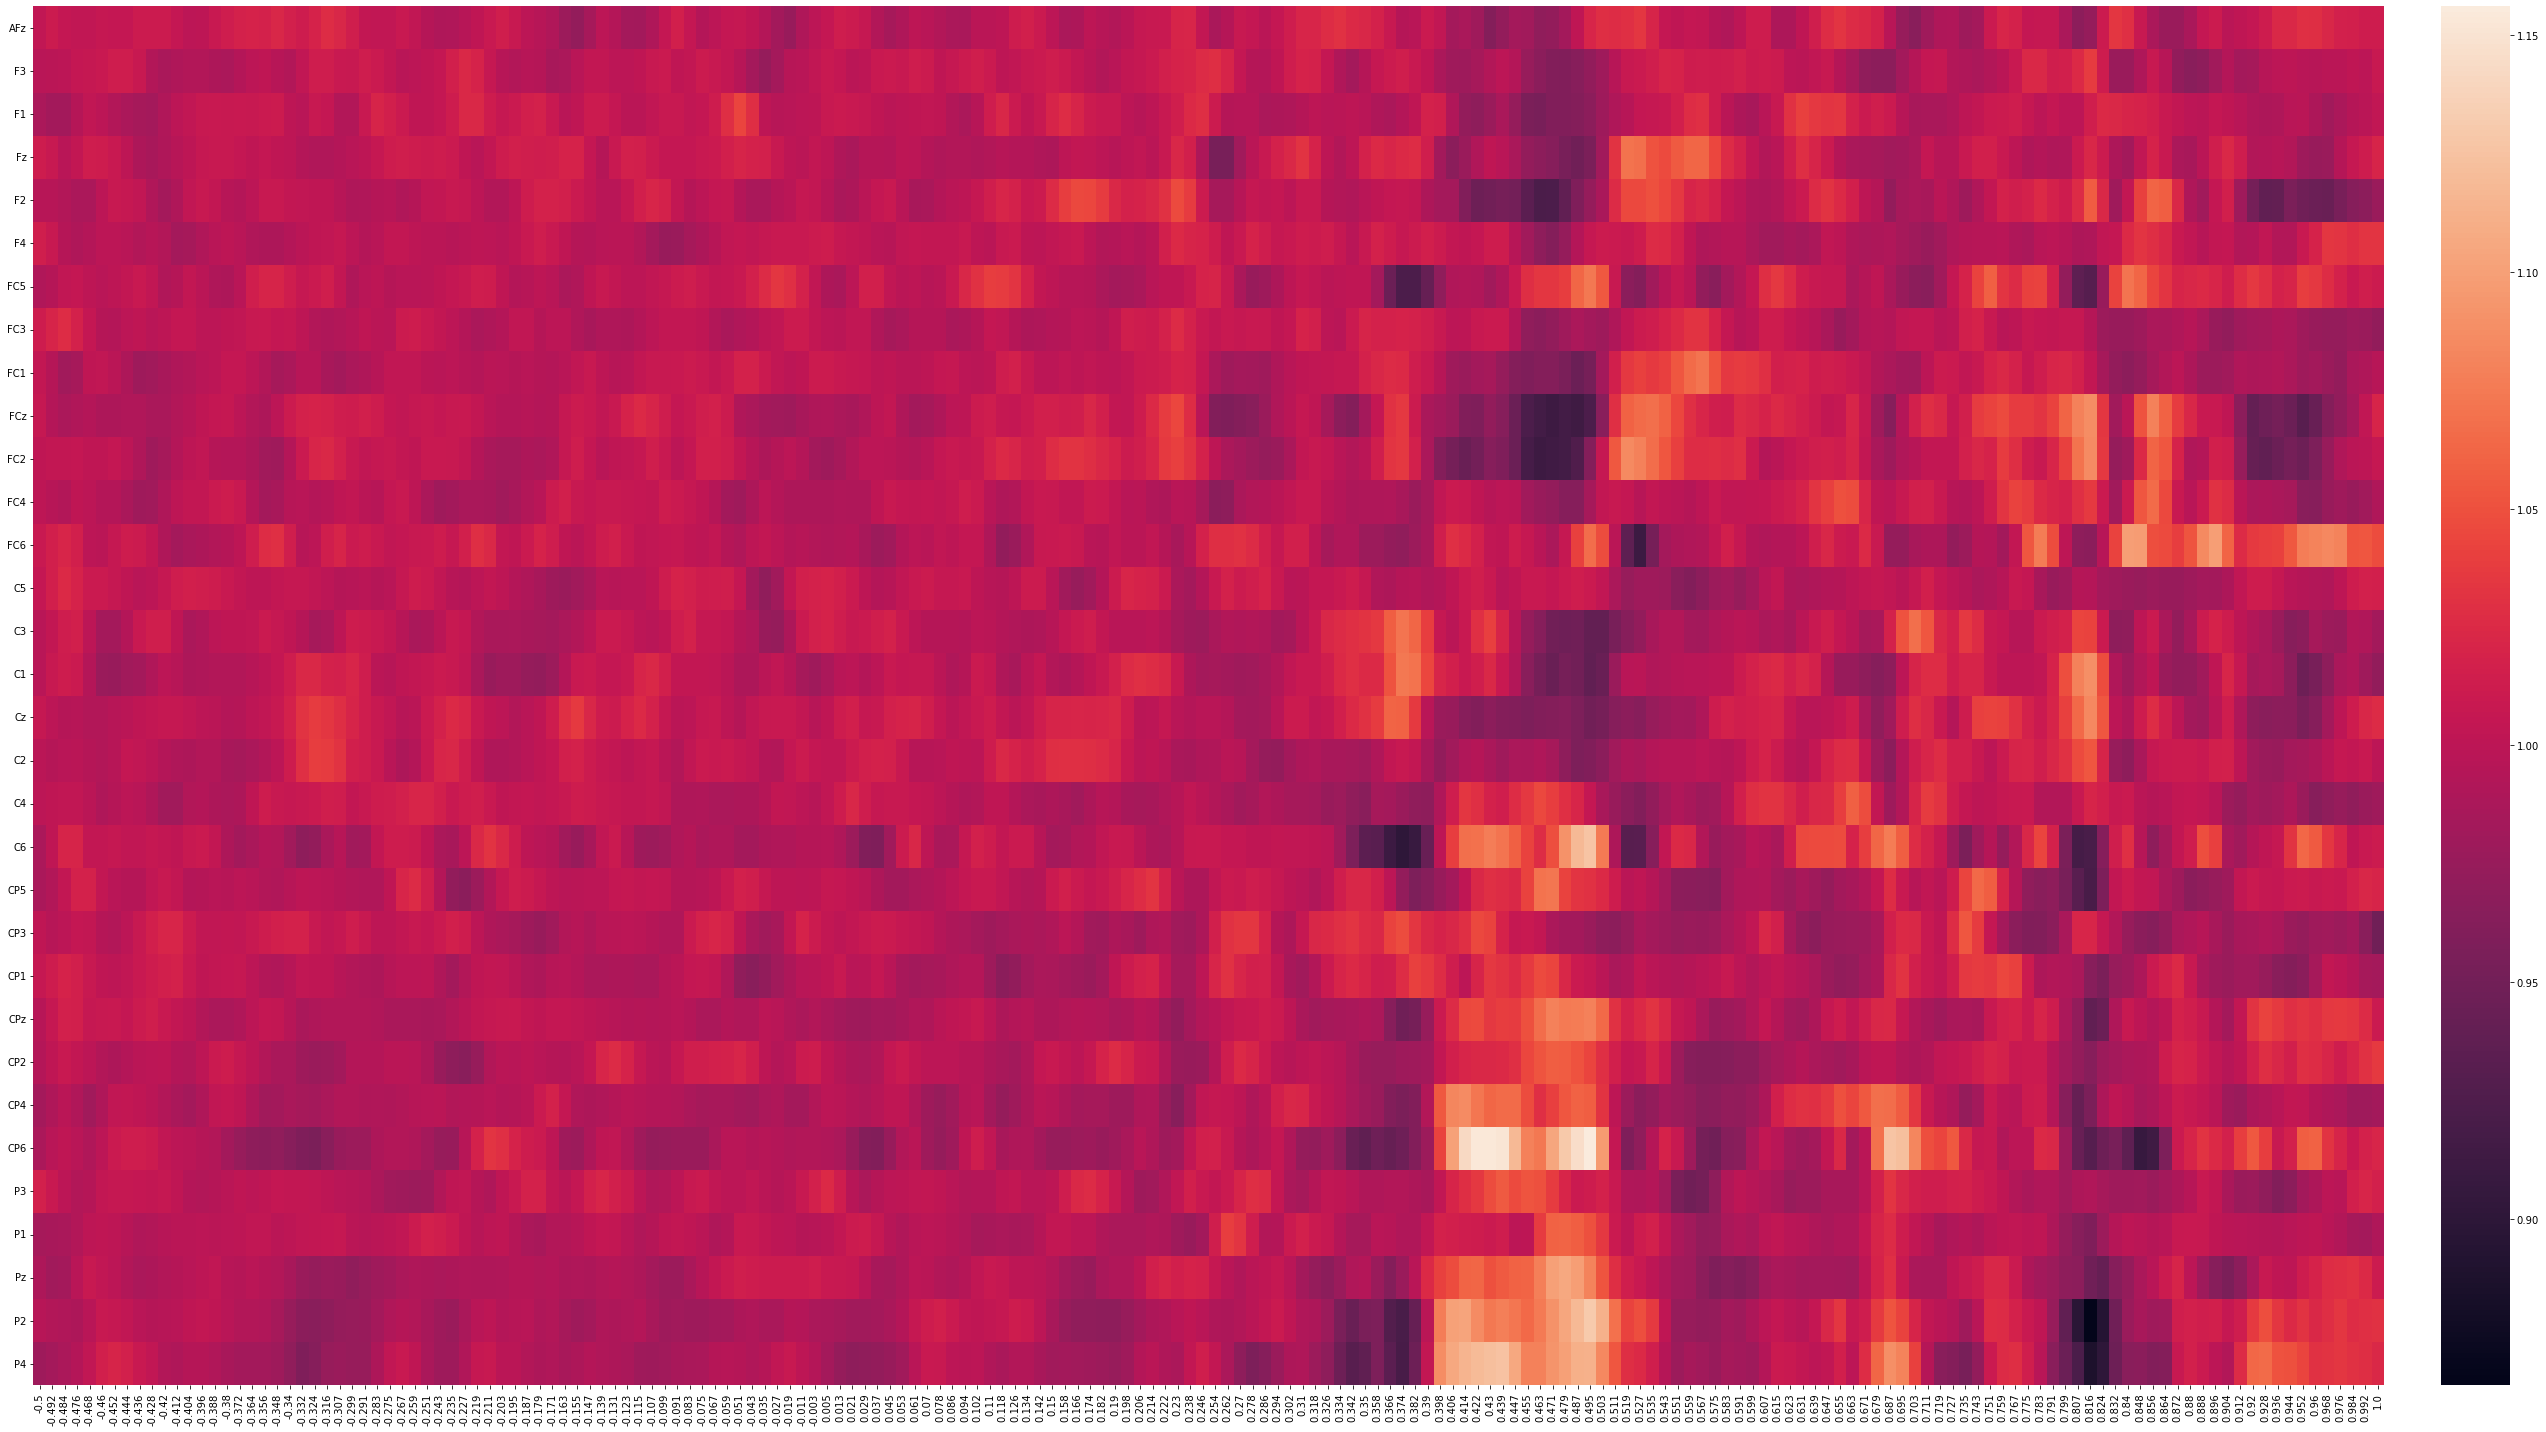

In [10]:
fig =plt.figure()
sns.heatmap(pd.DataFrame(avg_w), 
            xticklabels=timestep_labels,
            yticklabels=channel_names, 
            annot=False, cbar_kws={"pad":0.02})

fig.set_figwidth(40)
fig.set_figheight(20)
plt.tight_layout()

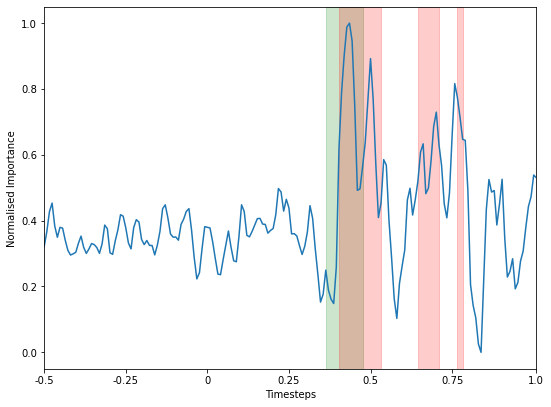

In [11]:
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler

plt.figure(figsize=(8,6))


scaler= MinMaxScaler()
scaled_avg_w= scaler.fit_transform(avg_w.sum(0).reshape(-1,1))
df= pd.DataFrame(scaled_avg_w)


plt.plot(df)
plt.xlabel("Timesteps")
plt.axvspan(107,121, color="green", alpha=0.2)
plt.axvspan(112,128, color="red", alpha=0.2)
plt.axvspan(142,150, color="red", alpha=0.2)
plt.axvspan(157,159, color="red", alpha=0.2)
plt.xticks([0,31,62,93,124,155,187],[-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0])
plt.ylabel("Normalised Importance")
plt.margins(x=0)
matplotlib.rcParams.update({"font.size":18})
plt.tight_layout()


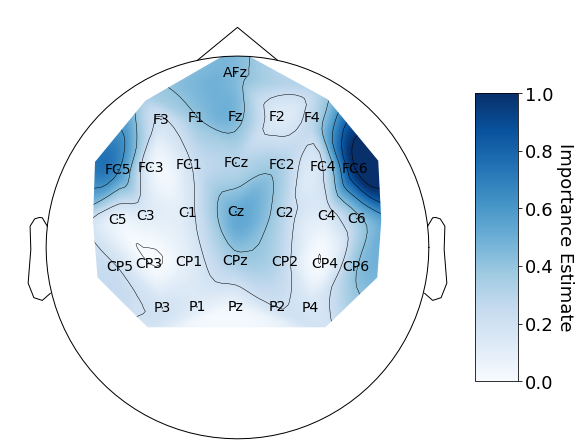

In [12]:
from sklearn.preprocessing import MinMaxScaler
import mne
info= mne.create_info(channel_names, sfreq=500, ch_types=32*["eeg"])
info.set_montage("standard_1020")

fig= plt.figure()
ax= plt.axes((0,0,1.5,1.5))

scaler= MinMaxScaler()
scaled_avg_w= scaler.fit_transform(avg_w.sum(1).reshape(-1,1))
# df= pd.DataFrame(scaled_avg_w.reshape(-1))

im, _= mne.viz.plot_topomap(
    scaled_avg_w.reshape(-1),
    info,
    ch_type= "eeg",
    sensors=True,
    names=channel_names,
    cmap="Blues",
    axes=ax,
    show=False,
    extrapolate="local"
#     sphere="eeglab"
)
fig.add_axes(ax)
cbar_ax= fig.add_axes([1.3,0.2, 0.1,1])
clb= fig.colorbar(im, cax=cbar_ax)
clb.set_label("Importance Estimate", rotation=270,labelpad=20)

for tt in plt.findobj(fig, matplotlib.text.Text):
    if tt.get_text() in channel_names:
        tt.set_fontsize(14)